In [ ]:
# Importando as blibiotecas
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from itertools import product

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [ ]:
url = 'https://raw.githubusercontent.com/aaasatoou/bootcamp_blue_Projeto2/main/Estudo%20COVID%20-%20Insights%20e%20Previs%C3%B5es/dados/Silver/datasets/serie%20temporal%20pais/S%C3%A9ries%20Temporais%20Espanha.csv'

serie_esp = pd.read_csv(url)
serie_esp.drop(['Unnamed: 0','Confirmed','Recovered','Ano','Mês'],
               axis=1,inplace=True)
serie_esp['Date'] = pd.to_datetime(serie_esp['Date'],format='%Y-%m-%d')
serie_esp.head()

,Date,Deaths
0,2020-01-22,0
1,2020-01-23,0
2,2020-01-24,0
3,2020-01-25,0
4,2020-01-26,0


In [ ]:
serie_esp.set_index('Date',inplace=True)
serie_esp.head()

,Deaths
Date,
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0


In [ ]:
# Selecionando apenas os primeiros meses do dataset
serie_esp = serie_esp[0:161]

In [ ]:
treino = serie_esp[0:131]
treino

,Deaths
Date,
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
...,...
2020-05-27,27117
2020-05-28,27119
2020-05-29,27121


In [ ]:
teste = serie_esp[131:161]
teste.head()

,Deaths
Date,
2020-06-01,27127
2020-06-02,27127
2020-06-03,27128
2020-06-04,27133
2020-06-05,27134


In [ ]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
p = range(0, 5, 1)
d = 1
q = range(0, 5, 1)
P = range(0, 5, 1)
D = 1
Q = range(0, 5, 1)
s = 2
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

625


In [ ]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 4, treino['Deaths'])
result_df

  0%|          | 0/625 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(0, 4, 0, 0)",1737.687025
1,"(0, 4, 2, 0)",1739.292410
2,"(0, 4, 1, 0)",1739.476906
3,"(4, 3, 0, 0)",1739.837021
4,"(1, 1, 0, 3)",1739.978222
...,...,...
436,"(0, 1, 0, 0)",1786.662434
437,"(3, 0, 0, 0)",1786.988219
438,"(2, 0, 0, 0)",1787.445139
439,"(1, 1, 0, 0)",1788.218525


In [ ]:
best_model = SARIMAX(treino['Deaths'], order=(0, 1, 4), seasonal_order=(0, 1, 0, 2)).fit(dis=-1)
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             Deaths   No. Observations:                  131
Model:             SARIMAX(0, 1, 4)x(0, 1, [], 2)   Log Likelihood                -878.176
Date:                            Mon, 16 Jan 2023   AIC                           1766.353
Time:                                    15:18:44   BIC                           1780.613
Sample:                                01-22-2020   HQIC                          1772.147
                                     - 05-31-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1822      0.058      3.132      0.002       0.068       0.296
ma.L2         -0.6958      0.057   

In [ ]:
fc = best_model.forecast(len(teste), alpha=0.05)

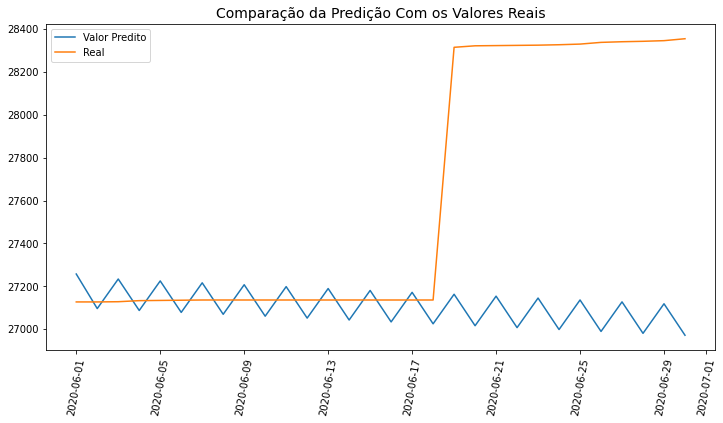

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Comparação da Predição Com os Valores Reais', fontsize=14)
plt.plot(teste.index,fc,label='Valor Predito')
plt.plot(teste.index,teste['Deaths'].values,label='Real')
plt.xticks(rotation=80)
plt.legend();

In [ ]:
print('MAPE:',mean_absolute_percentage_error(teste['Deaths'],fc))
print('MAE:',mean_absolute_error(teste['Deaths'],fc))
print('RMSE:',np.sqrt(mean_squared_error(teste['Deaths'],fc)))

MAPE: 0.01951041093520193
MAE: 550.808608172834
RMSE: 804.150173459786
